<a href="https://colab.research.google.com/github/rhiosutoyo/Teaching-Deep-Learning-and-Its-Applications/blob/main/10_2_inception_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inception Model
This code implements a deep learning pipeline to train an Inception v3 model on the CIFAR-10 dataset, a popular dataset consisting of 60,000 32x32 color images in 10 classes. The process includes data preprocessing, model modification to fit the CIFAR-10 classification task, training, and evaluation. The model is trained using Stochastic Gradient Descent (SGD) and Cross-Entropy Loss, and the training progress is displayed using the tqdm library for real-time monitoring. The final trained model is saved to disk for future use.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm

# Transforms are applied to the dataset to resize images to 299x299 pixels (required for Inception v3), convert images to tensors, and normalize them.
# Define transformations for the training and testing data
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize images for Inception model
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define the data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load the pretrained Inception model
model = models.inception_v3(pretrained=True)

# Modify the final layer to match the number of classes in CIFAR-10
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training function
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")

    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.logits, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.logits.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        progress_bar.set_postfix(loss=running_loss/len(train_loader), accuracy=100.*correct/total)

# Testing function
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    progress_bar = tqdm(test_loader, desc="Testing")

    with torch.no_grad():
        for inputs, targets in progress_bar:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar.set_postfix(loss=test_loss/len(test_loader), accuracy=100.*correct/total)

    return test_loss/len(test_loader), 100.*correct/total

# Main training loop
epochs = 2  # Reduce the number of epochs to reduce the training duration
for epoch in range(epochs):
    train(model, device, train_loader, criterion, optimizer, epoch)
    test_loss, test_accuracy = test(model, device, test_loader, criterion)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Save the model
torch.save(model.state_dict(), "inception_cifar10.pth")

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Testing: 100%|██████████| 313/313 [00:48<00:00,  6.44it/s, accuracy=95, loss=0.152]


Test Loss: 0.1522, Test Accuracy: 94.95%


Testing: 100%|██████████| 313/313 [00:47<00:00,  6.59it/s, accuracy=95.7, loss=0.132]


Test Loss: 0.1317, Test Accuracy: 95.70%


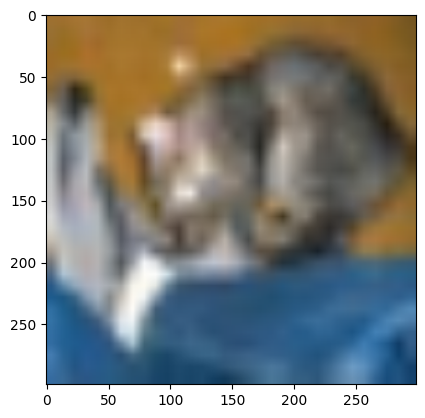

Predicted: cat


In [2]:
# Test with a single image
import matplotlib.pyplot as plt
import numpy as np

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Define the class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Get a single test image
dataiter = iter(test_loader)
images, labels = next(dataiter)
image = images[0].unsqueeze(0).to(device)

# Display the image
imshow(images[0].cpu())

# Perform inference
model.eval()
output = model(image)
_, predicted = torch.max(output, 1)
predicted_class = class_names[predicted.item()]
print(f"Predicted: {predicted_class}")

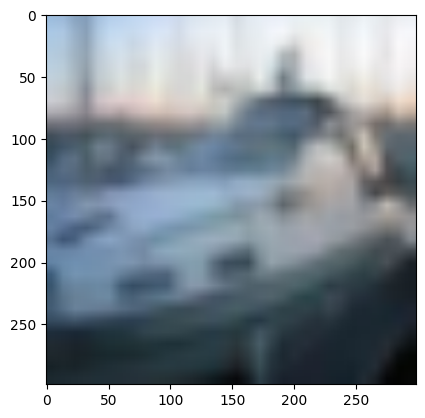

Predicted: ship


In [3]:
# Get a single test image
dataiter = iter(test_loader)
images, labels = next(dataiter)
image = images[2].unsqueeze(0).to(device)

# Display the image
imshow(images[2].cpu())

# Perform inference
model.eval()
output = model(image)
_, predicted = torch.max(output, 1)
predicted_class = class_names[predicted.item()]
print(f"Predicted: {predicted_class}")

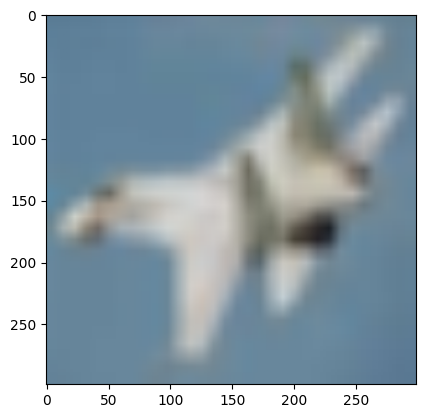

Predicted: dog


In [4]:
# Get a single test image
dataiter = iter(test_loader)
images, labels = next(dataiter)
image = images[10].unsqueeze(0).to(device)

# Display the image
imshow(images[10].cpu())

# Perform inference
model.eval()
output = model(image)
_, predicted = torch.max(output, 1)
predicted_class = class_names[predicted.item()]
print(f"Predicted: {predicted_class}")

# Suggested Activities

Improve the performance and robustness of the Inception v3 model trained on the CIFAR-10 dataset.

## Hyperparameter Tuning
* Try to implement several modifications to the existing code, including hyperparameter tuning, data augmentation, learning rate scheduling, model checkpointing, and other advanced techniques.
* Experiment with different learning rates and batch sizes.
* Try different optimizers such as Adam, RMSprop, or Adagrad.
* Increase the number of epochs and observe the effect on model performance.

## Data Augmentation
* Implement additional data augmentation techniques such as random rotations, flips, and color jitter to improve model generalization.